In [1]:
# Install required packages
!pip install gym
!pip install tensorflow

In [2]:
# Step 1: Environment Setup

# Import necessary libraries
import gym
import tensorflow as tf

# Verify the versions of Gym and TensorFlow
print(f'Gym version: {gym.__version__}')
print(f'TensorFlow version: {tf.__version__}')


Gym version: 0.25.2
TensorFlow version: 2.13.0


In [3]:
# Step 2: Data Collection

import numpy as np

# Generate synthetic traffic data
def generate_traffic_data(num_samples):
    # Generate random traffic flow values (e.g., vehicles per minute)
    traffic_flow = np.random.randint(50, 300, num_samples)

    # Generate random waiting time at the traffic signal
    waiting_time = np.random.uniform(10, 120, num_samples)

    # Combine traffic flow and waiting time as features
    traffic_data = np.column_stack((traffic_flow, waiting_time))

    # Generate random rewards (for demonstration purposes)
    rewards = np.random.rand(num_samples)

    return traffic_data, rewards

# Generate synthetic traffic data for 1000 samples
num_samples = 1000
traffic_data, rewards = generate_traffic_data(num_samples)

# Print the first few samples
print("Sample traffic data:")
print(traffic_data[:5])
print("\nSample rewards:")
print(rewards[:5])


Sample traffic data:
[[ 95.          50.61660521]
 [263.          85.85403685]
 [ 81.          78.64962925]
 [212.          38.50251195]
 [100.          84.42399093]]

Sample rewards:
[0.22640021 0.98788553 0.40913481 0.39816709 0.46505508]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Step 3: Traffic Signal Environment

import gym
from gym import spaces
import numpy as np

class TrafficSignalControlEnv(gym.Env):
    def __init__(self):
        super(TrafficSignalControlEnv, self).__init__()

        # Define the action space (e.g., traffic signal phase durations)
        self.action_space = spaces.Discrete(4)  # Example: 4 signal phases

        # Define the state space (e.g., traffic data)
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(2,),  # Example: traffic flow and waiting time
            dtype=np.float32
        )

        # Define other environment parameters
        self.max_steps = 1000
        self.current_step = 0

    def reset(self):
        # Reset the environment, return an initial state
        self.current_step = 0
        initial_state = np.random.rand(2)  # Replace with real initial state
        return initial_state

    def step(self, action):
        # Execute the selected action and return the next state, reward, done flag, and info
        reward = self.calculate_reward(action)  # Calculate reward based on the action
        next_state = np.random.rand(2)  # Replace with real next state
        done = self.current_step >= self.max_steps
        self.current_step += 1
        return next_state, reward, done, {}

    def calculate_reward(self, action):
        # Implement a custom reward function based on the action taken and the current state
        # Example: Reward based on the action (e.g., phase duration)
        if action == 0:
            reward = 0
        elif action == 1:
            reward = 1
        elif action == 2:
            reward = -1
        else:
            reward = 0
        return reward

    def render(self, mode='human'):
        # Optional: Implement a rendering method for visualization
        pass

    def close(self):
        # Optional: Clean up resources, if necessary
        pass

# Create an instance of the custom environment
env = TrafficSignalControlEnv()

# Test the environment by resetting and taking a few steps
initial_state = env.reset()
for _ in range(10):
    action = env.action_space.sample()  # Sample a random action
    next_state, reward, done, _ = env.step(action)
    print(f"Action: {action}, Next State: {next_state}, Reward: {reward}, Done: {done}")


Action: 3, Next State: [0.10992028 0.87901783], Reward: 0, Done: False
Action: 1, Next State: [0.36722404 0.97317953], Reward: 1, Done: False
Action: 3, Next State: [0.27135695 0.02939566], Reward: 0, Done: False
Action: 1, Next State: [0.00562697 0.07731069], Reward: 1, Done: False
Action: 3, Next State: [0.63917982 0.86074824], Reward: 0, Done: False
Action: 1, Next State: [0.40463913 0.52683018], Reward: 1, Done: False
Action: 2, Next State: [0.86159891 0.9793285 ], Reward: -1, Done: False
Action: 2, Next State: [0.97885623 0.06829537], Reward: -1, Done: False
Action: 0, Next State: [0.71476575 0.77552329], Reward: 0, Done: False
Action: 1, Next State: [0.49433589 0.54568276], Reward: 1, Done: False


In [5]:
# Step 4: Deep Q-Network (DQN)

import tensorflow as tf
from tensorflow.keras import layers

class DQN(tf.keras.Model):
    def __init__(self, num_actions):
        super(DQN, self).__init__()

        # Define the neural network architecture
        self.dense1 = layers.Dense(32, activation='relu')
        self.dense2 = layers.Dense(32, activation='relu')
        self.output_layer = layers.Dense(num_actions, activation='linear')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.output_layer(x)

# Example usage:
# Create an instance of the DQN model with a specified number of actions
num_actions = 4  # Replace with the actual number of actions in your environment
model = DQN(num_actions)
target_model = DQN(num_actions)

# Compile the model with an appropriate optimizer and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

In [6]:
# Step 5: Reinforcement Learning Algorithm

import numpy as np

def deep_q_learning(env, model, num_episodes, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
    history = {'episode': [], 'total_reward': []}
    epsilon = epsilon_start

    for episode in range(1, num_episodes + 1):
        state = env.reset()
        total_reward = 0

        while True:
            # Choose an action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(np.expand_dims(state, axis=0))
                action = np.argmax(q_values)

            next_state, reward, done, _ = env.step(action)

            # Update the Q-values using the Bellman equation
            target = reward + gamma * np.max(model.predict(np.expand_dims(next_state, axis=0)))
            target = np.where(done, reward, target)

            with tf.GradientTape() as tape:
                q_values = model(np.expand_dims(state, axis=0))
                loss = tf.keras.losses.MSE(target, q_values[0, action])

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            total_reward += reward
            state = next_state

            if done:
                break

        # Decay epsilon to encourage exploitation over time
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # Log episode results
        history['episode'].append(episode)
        history['total_reward'].append(total_reward)
        print(f"Episode {episode}/{num_episodes}, Total Reward: {total_reward}")

    return history

# Example usage:
# num_episodes = 1000  # Adjust the number of episodes as needed
# history = deep_q_learning(env, model, num_episodes)

# Optionally, you can plot and analyze the training results using 'history'.


In [7]:
# Step 6: Training Loop

# Define hyperparameters
num_episodes = 10 # 1000
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995

# Initialize the DQN model
num_actions = 4  # Replace with the actual number of actions in your environment
model = DQN(num_actions)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Initialize the environment
env = TrafficSignalControlEnv()

# Initialize training history for logging
history = {'episode': [], 'total_reward': []}

# Define Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
epsilon = epsilon_start
best_total_reward = -float('inf')  # Initialize with negative infinity
target_total_reward = 3 # 200  # Define your own target reward threshold

for episode in range(1, num_episodes + 1):
    state = env.reset()
    total_reward = 0

    while True:
        # Choose an action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            q_values = model.predict(np.expand_dims(state, axis=0))
            action = np.argmax(q_values)

        next_state, reward, done, _ = env.step(action)

        # Update the Q-values using the Bellman equation
        target = reward + gamma * np.max(model.predict(np.expand_dims(next_state, axis=0)))
        target = np.where(done, reward, target)

        with tf.GradientTape() as tape:
            q_values = model(np.expand_dims(state, axis=0))
            loss = tf.keras.losses.MeanSquaredError()(target, q_values)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        total_reward += reward
        state = next_state

        if done:
            break

    # Decay epsilon to encourage exploitation over time
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

    # Log episode results
    history['episode'].append(episode)
    history['total_reward'].append(total_reward)
    print(f"Episode {episode}/{num_episodes}, Total Reward: {total_reward}")

    # Exit the loop if the target total reward is achieved
    if total_reward >= target_total_reward:
        print(f"Target reward of {target_total_reward} achieved. Exiting training.")
        break

    # Update the best total reward
    if total_reward > best_total_reward:
        best_total_reward = total_reward

# Optionally, you can plot and analyze the training results using 'history'.


1/1 [==============================] - 0s 44ms/step
Episode 1/10, Total Reward: -26
1/1 [==============================] - 0s 23ms/step
Episode 2/10, Total Reward: -35
1/1 [==============================] - 0s 22ms/step
Episode 3/10, Total Reward: -47
1/1 [==============================] - 0s 21ms/step
Episode 4/10, Total Reward: 23
Target reward of 3 achieved. Exiting training.


In [8]:
# Step 7: Testing and Evaluation

# Define the number of episodes for testing
num_test_episodes = 5 # 100

test_rewards = []  # To store rewards for each test episode

for episode in range(1, num_test_episodes + 1):
    state = env.reset()  # Reset the environment for each episode
    total_reward = 0

    while True:
        q_values = model.predict(np.expand_dims(state, axis=0) , steps=1)
        action = np.argmax(q_values)  # Choose the action with the highest Q-value

        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        state = next_state

        if done:
            break

    test_rewards.append(total_reward)

    print(f"Test Episode {episode}/{num_test_episodes}, Total Reward: {total_reward}")

# Calculate and print the average test reward
average_test_reward = sum(test_rewards) / num_test_episodes
print(f"Average Test Reward: {average_test_reward}")


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
Test Episode 1/5, Total Reward: -483
1/1 [==============================] - 0s 21ms/step
Test Episode 2/5, Total Reward: -475
1/1 [==============================] - 0s 21ms/step
Test Episode 3/5, Total Reward: -497
1/1 [==============================] - 0s 36ms/step
Test Episode 4/5, Total Reward: -468
1/1 [==============================] - 0s 27ms/step
Test Episode 5/5, Total Reward: -486
Average Test Reward: -481.8


In [9]:
# Step 8: Optimization - Adding Experience Replay and Target Networks

from collections import deque
import random

# Define the size of the replay buffer
replay_buffer_size = 100 # 10000
replay_buffer = deque(maxlen=replay_buffer_size)

# Create the target model with the same architecture as the main model
target_model = DQN(num_actions)

# Manually set the input shape for the target model
input_shape = env.observation_space.shape
target_model.build((None,) + input_shape)

# Initialize the target model's weights with the same values as the main model
target_model.set_weights(model.get_weights())



# Define hyperparameters for experience replay
batch_size = 64
update_target_frequency = 10  # Update the target network every N episodes

# Training loop
for episode in range(1, num_episodes + 1):
    state = env.reset()
    total_reward = 0

    while True:
        # Choose an action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            q_values = model.predict(np.expand_dims(state, axis=0))
            action = np.argmax(q_values)

        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        # Store the transition in the replay buffer
        replay_buffer.append((state, action, reward, next_state, done))

        # Update the Q-values using experience replay
        if len(replay_buffer) >= batch_size:
            minibatch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*minibatch)

            targets = rewards + (1 - np.array(dones)) * gamma * np.max(target_model.predict(np.array(next_states), steps=1), axis=1)

            with tf.GradientTape() as tape:
                q_values = model(np.array(states))
                selected_action_q_values = tf.reduce_sum(q_values * tf.one_hot(actions, num_actions), axis=1)
                loss = tf.keras.losses.MeanSquaredError()(targets, selected_action_q_values)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        state = next_state

        if done:
            break

    # Decay epsilon to encourage exploitation over time
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

    # Update the target network every N episodes
    if episode % update_target_frequency == 0:
        target_model.set_weights(model.get_weights())  # Update the target network

    # Log episode results
    history['episode'].append(episode)
    history['total_reward'].append(total_reward)
    print(f"Episode {episode}/{num_episodes}, Total Reward: {total_reward}")

# Optionally, you can plot and analyze the training results using 'history'.


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step
Episode 6/10, Total Reward: 33
1/1 [==============================] - 0s 25ms/step
Episode 7/10, Total Reward: 64
1/1 [==============================] - 0s 34ms/step
Episode 8/10, Total Reward: 85
1/1 [==============================] - 0s 33ms/step
Episode 9/10, Total Reward: 71
1/1 [==============================] - 0s 50ms/step
Episode 10/10, Total Reward: 46


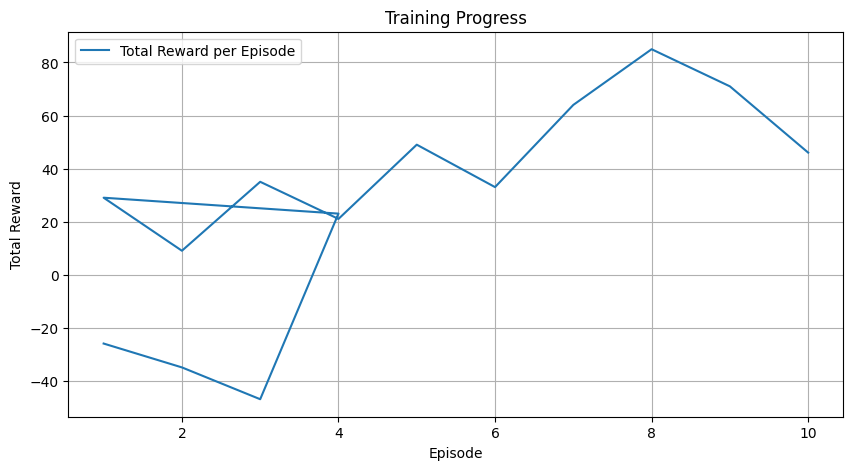

In [10]:
import matplotlib.pyplot as plt

# Step 9: Visualization

# Visualize the training results

# Plot the total reward per episode
plt.figure(figsize=(10, 5))
plt.plot(history['episode'], history['total_reward'], label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, you can further analyze and visualize other metrics or aspects of your training results, such as loss values, exploration vs. exploitation, and more, depending on your specific requirements.


In [11]:
"""
# Step 1: Environment Setup

# Step 2: Data Collection

# Step 3: Traffic Signal Environment
import gym

# Step 4: Deep Q-Network (DQN)
import tensorflow as tf
from tensorflow.keras import layers

# Step 5: Reinforcement Learning Algorithm

# Step 6: Training Loop

# Step 7: Testing and Evaluation

# Step 8: Optimization

# Step 9: Visualization

# Step 10: Documentation

# Step 11: Deployment (Optional)

"""


'\n# Step 1: Environment Setup\n\n# Step 2: Data Collection\n\n# Step 3: Traffic Signal Environment\nimport gym\n\n# Step 4: Deep Q-Network (DQN)\nimport tensorflow as tf\nfrom tensorflow.keras import layers\n\n# Step 5: Reinforcement Learning Algorithm\n\n# Step 6: Training Loop\n\n# Step 7: Testing and Evaluation\n\n# Step 8: Optimization\n\n# Step 9: Visualization\n\n# Step 10: Documentation\n\n# Step 11: Deployment (Optional)\n\n'